In [1]:
### Using networkx package, we generate LFR_benchmark_graph with the folllwing parameters
import networkx as nx
from networkx.generators.community import LFR_benchmark_graph

n = 200
tau1 = 3  # Power-law exponent for the degree distribution
tau2 = 1.5 # Power-law exponent for the community size distribution 
            #S hould be >1
mu = 0.2 # Mixing parameter
avg_deg = 25 # Average Degree
max_deg = 60 # Max Degree
min_commu = 30 # Min Community Size
max_commu = 60 # Max Community Size


G = LFR_benchmark_graph(
    n, tau1, tau2, mu, average_degree=avg_deg, max_degree=max_deg, min_community=min_commu, max_community=max_commu, 
    seed=2
)

pos = nx.spring_layout(G)

# nx.draw(G, pos=nx.spring_layout(G),node_color='r', node_size=3, edge_color='b')  # Draw the graph generated above


G = nx.Graph(G) # Remove multi-edges

selfloop_edges = list(nx.selfloop_edges(G)) # a list of self loops

G.remove_edges_from(selfloop_edges) # Remove self-loops

### LFR benchmark has intrinsic community structure, we get this structure and store it in a dict.
intrinsic_communities = {frozenset(G.nodes[v]["community"]) for v in G}
intrinsic_membership = {}
for node in range(G.number_of_nodes()):
    for index, inner_set in enumerate(intrinsic_communities):
        if node in inner_set:
            intrinsic_membership[node] = index
            break
# intrinsic_membership = list(intrinsic_membership.values())

# We also store the community dict in list and clustering forms.
intrinsic_list = list(intrinsic_membership.values())
from clusim.clustering import Clustering
intrinsic_clustering = Clustering(elm2clu_dict={i: [intrinsic_membership[i]] for i in intrinsic_membership.keys()})

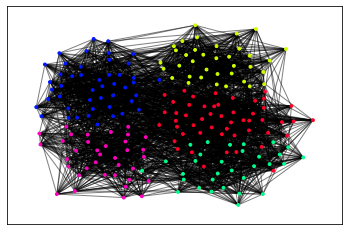

In [2]:
import matplotlib
import matplotlib.pyplot as plt
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G,
                      pos,
                      node_size=8,
                      cmap=matplotlib.colormaps.get_cmap('gist_rainbow'),
                      node_color=intrinsic_list
                      )
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/11/29 11:04:47 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/11/29 11:04:48 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
23/11/29 11:04:55 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


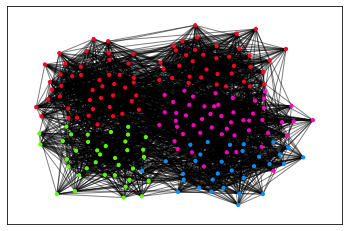

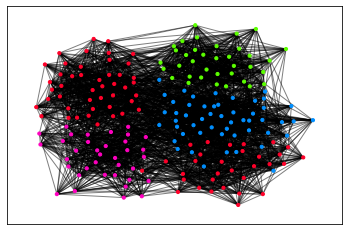

[1.0, 0.8502907779225258, 1.0, 0.6902231197643377]


In [3]:
### 7 My Correct LLE method
from auxpack.lle import lle
#from WGE.lle import lle_cupy as lle
D = 5
lle_embd = lle(G, D)
#print(EE(intrinsic_list, intrinsic_clustering, lle_embd))

### import my package for clustering evaluation, compared to the instrinsic community structure
from auxpack.evaluate_embedding import evaluate_embedding as EE

import networkx as nx

from networkx.generators.community import LFR_benchmark_graph

import matplotlib
import matplotlib.pyplot as plt

from pyspark.ml.clustering import KMeans

from pyspark.sql import SparkSession
from pyspark.ml.linalg import Vectors


from sklearn.metrics import normalized_mutual_info_score
from clusim.clustering import Clustering
import clusim.sim as sim

lle_vec = [Vectors.dense(row) for row in lle_embd]
lle_prep = SparkSession.builder.getOrCreate().\
                createDataFrame([(vector,) for vector in lle_vec], ["embd"])

euclid_kmeans = KMeans(k=4, featuresCol="embd")
cosine_kmeans = KMeans(k=4, featuresCol="embd", distanceMeasure="cosine")
lle_euclid_model = euclid_kmeans.fit(lle_prep)
lle_cosine_model = cosine_kmeans.fit(lle_prep)

# Add the cluster assignment to the DataFrame
lle_euclid = lle_euclid_model.transform(lle_prep)
lle_cosine = lle_cosine_model.transform(lle_prep)

# Extract the cluster assignment and convert it to a list
lle_euclid_membership = lle_euclid.select("prediction").rdd.flatMap(lambda x: x).collect()
lle_cosine_membership = lle_cosine.select("prediction").rdd.flatMap(lambda x: x).collect()

nx.draw_networkx_nodes(G,
              pos,
              #louvain_membership.keys(),
              node_size=10,
              cmap=matplotlib.colormaps.get_cmap('gist_rainbow'),
              node_color=list(lle_euclid_membership)
              )
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()
nx.draw_networkx_nodes(G,
        pos,
        #louvain_membership.keys(),
        node_size=10,
        cmap=matplotlib.colormaps.get_cmap('gist_rainbow'),
        node_color=list(lle_cosine_membership)
        )
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()

print(EE(intrinsic_list, intrinsic_clustering, lle_embd))

In [4]:
# The four numbers are NMI_Euclidean, NMI_Spherical, ECS_Euclidean, ECS_Spherical.

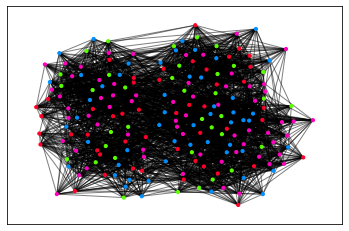

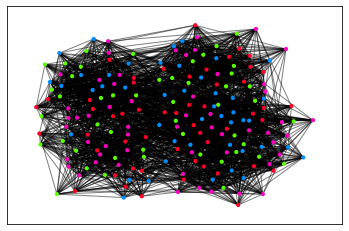

[0.010989178428462216, 0.01989942137107632, 0.19102915833320325, 0.19518367292086047]


In [5]:
### Locally Linear Method from GEM package
from gem.embedding.lle import LocallyLinearEmbedding


lle_model = LocallyLinearEmbedding(d=D)

lle_embd = lle_model.learn_embedding(graph=G, is_weighted=True, no_python=True)


lle_vec = [Vectors.dense(row) for row in lle_embd]
lle_prep = SparkSession.builder.getOrCreate().\
                createDataFrame([(vector,) for vector in lle_vec], ["embd"])

euclid_kmeans = KMeans(k=4, featuresCol="embd")
cosine_kmeans = KMeans(k=4, featuresCol="embd", distanceMeasure="cosine")
lle_euclid_model = euclid_kmeans.fit(lle_prep)
lle_cosine_model = cosine_kmeans.fit(lle_prep)

# Add the cluster assignment to the DataFrame
lle_euclid = lle_euclid_model.transform(lle_prep)
lle_cosine = lle_cosine_model.transform(lle_prep)

# Extract the cluster assignment and convert it to a list
lle_euclid_membership = lle_euclid.select("prediction").rdd.flatMap(lambda x: x).collect()
lle_cosine_membership = lle_cosine.select("prediction").rdd.flatMap(lambda x: x).collect()

nx.draw_networkx_nodes(G,
              pos,
              #louvain_membership.keys(),
              node_size=10,
              cmap=matplotlib.colormaps.get_cmap('gist_rainbow'),
              node_color=list(lle_euclid_membership)
              )
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()
nx.draw_networkx_nodes(G,
        pos,
        #louvain_membership.keys(),
        node_size=10,
        cmap=matplotlib.colormaps.get_cmap('gist_rainbow'),
        node_color=list(lle_cosine_membership)
        )
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()

print(EE(intrinsic_list, intrinsic_clustering, lle_embd))